In [1]:
import yfinance as yf   
import pandas as pd
import numpy as np
from fredapi import Fred
import datetime as dt
from urllib.parse import urlparse
import os
import matplotlib.pyplot as plt
from data_processor import DataProcessor
from models import ArimaModel, CNNModel, LSTMModel
from helper import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend, optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Ticker symbols mapping
# key: Yahoo Finance ticker symbol
# value: data frame column name
# 'USDJPY=X': 'usdjpy', 'USDCNY=X': 'usdcny', 'BTC-USD': 'btc',

ticker_dict = {
        'AUDUSD=X': 'audusd',
        'TIO=F': 'iron_ore',
        'GC=F': 'gold',
        '^VIX': 'vix',
    }

In [3]:
data_file = f"./data.parquet"


# Check if data file exists and is recent (e.g., less than 1 hour old)
if os.path.exists(data_file):
    file_age = dt.datetime.now() - dt.datetime.fromtimestamp(os.path.getmtime(data_file))
    
    if file_age < dt.timedelta(hours=1):  # Data is fresh
        print(f"Loading existing data from {data_file} (age: {file_age})")
        df = pd.read_parquet(data_file)
        df = df.ffill().bfill()  # Fill missing values
    else:
        print("Data file is outdated, downloading fresh data...")
        df = download_and_process(ticker_dict=ticker_dict, data_file=data_file)
else:
    print("No existing data file found, downloading...")
    df = download_and_process(ticker_dict=ticker_dict, data_file=data_file)

print(df.tail())

Loading existing data from ./data.parquet (age: 0:32:06.120159)
                       audusd         gold    vix     sma_5    sma_10  \
date                                                                    
2025-08-17 23:00:00  0.651466  3371.800049  15.08  0.651082  0.651214   
2025-08-18 00:00:00  0.651508  3385.300049  15.08  0.651183  0.651143   
2025-08-18 01:00:00  0.652316  3392.300049  15.08  0.651424  0.651227   
2025-08-18 02:00:00  0.651678  3392.300049  15.08  0.651576  0.651264   
2025-08-18 03:00:00  0.652231  3397.699951  15.08  0.651840  0.651393   

                        ema_5    ema_10  momentum_5  momentum_10     std_5  \
date                                                                         
2025-08-17 23:00:00  0.651157  0.651160    0.000678    -0.000595  0.000229   
2025-08-18 00:00:00  0.651274  0.651224    0.000501    -0.000710  0.000290   
2025-08-18 01:00:00  0.651621  0.651422    0.001206     0.000846  0.000575   
2025-08-18 02:00:00  0.651640  0.6

In [4]:
# Create LSTM model instance
lstm_model = LSTMModel(data=df, target_col='audusd', train_ratio=0.80)

# Train the model with default parameters
lstm_model.fit(
    seq_len=20, 
    forecast_horizon=30, 
    epochs=100, 
    batch_size=64, 
    validation_split=0.2, 
    patience=20, 
    verbose=1
)

=== Starting LSTM Model Training Pipeline ===
1. Preparing data...
seq_len=20, forecast_horizon=30
Train size: 3451, Test size: 863
Shapes -> train_x: (3402, 20, 16) train_y: (3402, 30) y0_train: (3402, 30)
Shapes -> test_x: (814, 20, 16) test_y: (814, 30) y0_test: (814, 30)
2. Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,774 (108.49 KB)

 Trainable params: 27,774 (108.49 KB)

 Non-trainable params: 0 (0.00 B)

3. Training model...
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5278 - mae: 0.5375 
Epoch 1: val_loss improved from None to 0.01976, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4584 - mae: 0.4986 - val_loss: 0.0198 - val_mae: 0.0970 - learning_rate: 5.0000e-04
Epoch 2/100
30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3272 - mae: 0.4173
Epoch 2: val_loss improved from 0.01976 to 0.01046, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2909 - mae: 0.3929 - val_loss: 0.0105 - val_mae: 0.0658 - learning_rate: 5.0000e-04
Epoch 3/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2159 - mae: 0.3381
Epoch 3: val_loss improved from 0.01046 to 0.00615, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1933 - mae: 0.3165 - val_loss: 0.0061 - val_mae: 0.0484 - learning_rate: 5.0000e-04
Epoch 4/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1456 - mae: 0.2721
Epoch 4: val_loss improved from 0.00615 to 0.00364, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1328 - mae: 0.2582 - val_loss: 0.0036 - val_mae: 0.0371 - learning_rate: 5.0000e-04
Epoch 5/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1066 - mae: 0.2268
Epoch 5: val_loss improved from 0.00364 to 0.00244, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0953 - mae: 0.2150 - val_loss: 0.0024 - val_mae: 0.0298 - learning_rate: 5.0000e-04
Epoch 6/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0752 - mae: 0.1884
Epoch 6: val_loss improved from 0.00244 to 0.00180, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0690 - mae: 0.1800 - val_loss: 0.0018 - val_mae: 0.0247 - learning_rate: 5.0000e-04
Epoch 7/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0498 - mae: 0.1521
Epoch 7: val_loss improved from 0.00180 to 0.00136, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0479 - mae: 0.1476 - val_loss: 0.0014 - val_mae: 0.0207 - learning_rate: 5.0000e-04
Epoch 8/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 - mae: 0.1323
Epoch 8: val_loss improved from 0.00136 to 0.00097, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0372 - mae: 0.1281 - val_loss: 9.7242e-04 - val_mae: 0.0175 - learning_rate: 5.0000e-04
Epoch 9/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318 - mae: 0.1177
Epoch 9: val_loss improved from 0.00097 to 0.00071, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284 - mae: 0.1110 - val_loss: 7.1434e-04 - val_mae: 0.0148 - learning_rate: 5.0000e-04
Epoch 10/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mae: 0.0957
Epoch 10: val_loss improved from 0.00071 to 0.00060, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - mae: 0.0939 - val_loss: 5.9979e-04 - val_mae: 0.0129 - learning_rate: 5.0000e-04
Epoch 11/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 - mae: 0.0823
Epoch 11: val_loss improved from 0.00060 to 0.00050, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - mae: 0.0789 - val_loss: 4.9752e-04 - val_mae: 0.0110 - learning_rate: 5.0000e-04
Epoch 12/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - mae: 0.0693
Epoch 12: val_loss improved from 0.00050 to 0.00038, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mae: 0.0662 - val_loss: 3.7988e-04 - val_mae: 0.0094 - learning_rate: 5.0000e-04
Epoch 13/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - mae: 0.0608
Epoch 13: val_loss improved from 0.00038 to 0.00027, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.0580 - val_loss: 2.7294e-04 - val_mae: 0.0081 - learning_rate: 5.0000e-04
Epoch 14/100
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - mae: 0.0516
Epoch 14: val_loss did not improve from 0.00027
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - mae: 0.0500 - val_loss: 2.7474e-04 - val_mae: 0.0078 - learning_rate: 5.0000e-04
Epoch 15/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - mae: 0.0447
Epoch 15: val_loss improved from 0.00027 to 0.00021, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0433 - val_loss: 2.1077e-04 - val_mae: 0.0068 - learning_rate: 5.0000e-04
Epoch 16/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mae: 0.0396
Epoch 16: val_loss did not improve from 0.00021
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - mae: 0.0399 - val_loss: 2.2765e-04 - val_mae: 0.0066 - learning_rate: 5.0000e-04
Epoch 17/100
35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - mae: 0.0359
Epoch 17: val_loss did not improve from 0.00021
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - mae: 0.0347 - val_loss: 2.2361e-04 - val_mae: 0.0062 - learning_rate: 5.0000e-04
Epoch 18/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mae: 0.0351
Epoch 18: val_loss did not improve from 0.00021
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mae: 0.0340 - val_loss: 2.3908e-04 - val_mae: 0.0061 - learning_rate: 5.0000e-04
Epoch 19/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.003

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0240 - val_loss: 1.7064e-04 - val_mae: 0.0053 - learning_rate: 5.0000e-04
Epoch 24/100
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mae: 0.0215
Epoch 24: val_loss did not improve from 0.00017
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0215 - val_loss: 1.7203e-04 - val_mae: 0.0051 - learning_rate: 5.0000e-04
Epoch 25/100
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mae: 0.0210
Epoch 25: val_loss did not improve from 0.00017
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0201 - val_loss: 1.7558e-04 - val_mae: 0.0052 - learning_rate: 5.0000e-04
Epoch 26/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0198
Epoch 26: val_loss did not improve from 0.00017
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0191 - val_loss: 1.7298e-04 - val_mae: 0.0051 - learning_rate: 5.0000e-04
Epoch 27/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.002

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0185 - val_loss: 1.5509e-04 - val_mae: 0.0050 - learning_rate: 5.0000e-04
Epoch 28/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mae: 0.0178   
Epoch 28: val_loss did not improve from 0.00016
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0171 - val_loss: 1.5626e-04 - val_mae: 0.0051 - learning_rate: 5.0000e-04
Epoch 29/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0190
Epoch 29: val_loss did not improve from 0.00016
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mae: 0.0177 - val_loss: 1.8474e-04 - val_mae: 0.0050 - learning_rate: 5.0000e-04
Epoch 30/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0157
Epoch 30: val_loss improved from 0.00016 to 0.00014, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0164 - val_loss: 1.3835e-04 - val_mae: 0.0049 - learning_rate: 5.0000e-04
Epoch 31/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0178
Epoch 31: val_loss improved from 0.00014 to 0.00012, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0165 - val_loss: 1.2395e-04 - val_mae: 0.0047 - learning_rate: 5.0000e-04
Epoch 32/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0155
Epoch 32: val_loss improved from 0.00012 to 0.00012, saving model to LSTM-weights-best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0151 - val_loss: 1.2180e-04 - val_mae: 0.0047 - learning_rate: 5.0000e-04
Epoch 33/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0153   
Epoch 33: val_loss did not improve from 0.00012

Epoch 33: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0156 - val_loss: 1.6852e-04 - val_mae: 0.0049 - learning_rate: 5.0000e-04
Epoch 34/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - mae: 0.0152
Epoch 34: val_loss did not improve from 0.00012
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mae: 0.0151 - val_loss: 1.5655e-04 - val_mae: 0.0048 - learning_rate: 5.0000e-05
Epoch 35/100
35/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0153   
Epoch 35: val_loss did not improve from 0.00012
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mae: 0.0143 - val_loss: 1.5286e-04 - val_mae: 0.0047 - learni

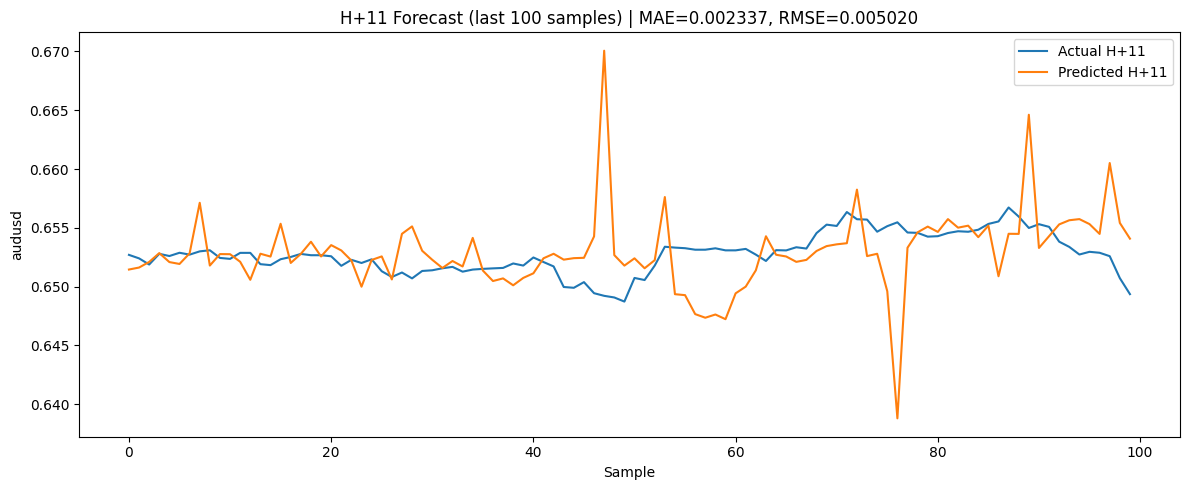

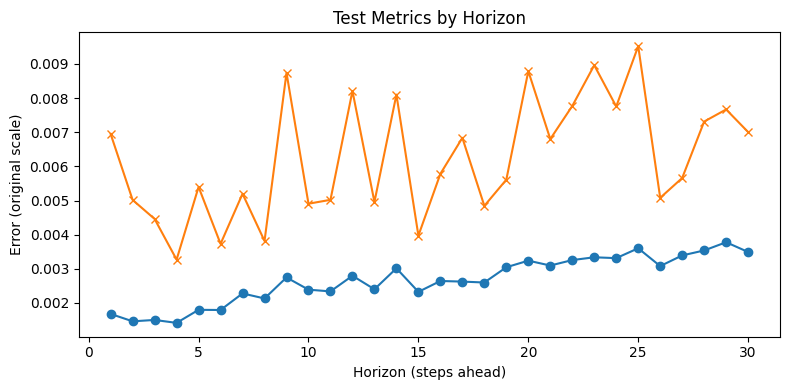

In [6]:

# Plot predictions for horizon H+11 (index 10)
lstm_model.plot_results(N=100, horizon=10)

# Plot MAE by horizon
lstm_model.plot_metrics_by_horizon()

# Get specific metrics


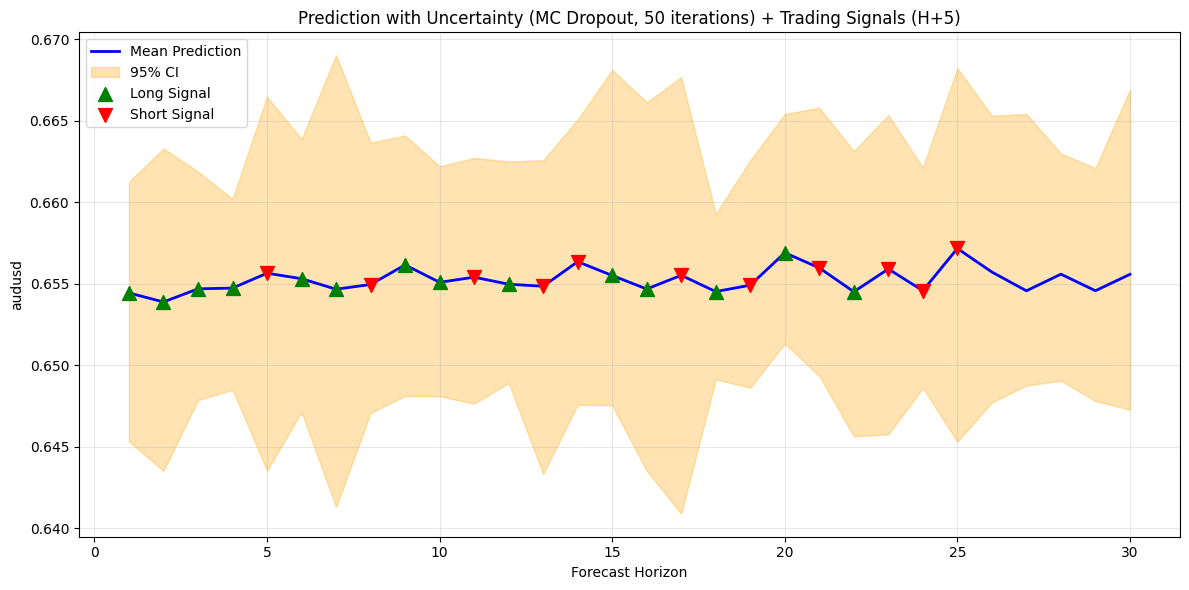

In [8]:
mean_pred, lower, upper, signals_df = lstm_model.predict_with_uncertainty(signal=True)